In [1]:
# import packages / functions
import pickle
import re
import matplotlib.pyplot as plt
from dark_ub_functions import cosine_similarity, return_ion_types
import numpy as np

In [2]:
# this script analyzes at LysC Ub peptide fragmentation

The picked data file can be downloaded at the following link: https://drive.google.com/file/d/13oJaa3bwfD6jsiZzMYeMd4DYZb39XNUP/view

In [3]:
# import data
# you may need to edit the picked_path depending on where the data is saved
pickled_path = 'Edgington2024_DarkUbiquitylome_Data/Edgington2024_dark_ub_pickled_dict.pkl'

try:
    with open(pickled_path, 'rb') as f:
        loaded_dict = pickle.load(f)
    print("Dictionary loaded successfully.")
except Exception as e:
    print(f"Failed to load dictionary: {e}")

Dictionary loaded successfully.


The structure of loaded_dict is as follows:

Top-Level Keys: 'trypsin' and 'LysC' represent different protease digestion methods done in Akimov et al. For this script, we only use the data from the trypsin experiments.

Sub-Level 1 Keys: 'Prosit' and 'experimental' represent the Prosit predicted libraries and the experimental data, respectively.

Sub-Level 2 Keys: 'modified' and 'unmodified' represent the modification status of precursors. In this case, modified means a KGG modification.

Sub-level 3 Keys: Different precursors in the structure ('PEPTIDE' : str, charge : int).

Sub-level 4 Keys: Attributes include:

    RT: Retention time in seconds (float).
    modseq: Modified sequence (str).
    mz_array: Array of mass-to-charge ratio values (np.array).
    intensity_array: Array of intensity values (np.array).
    summed_ion_intensity: Summed ion intensity (float).
    ion_df: Dataframe of matched fragment ions and their intensities

The ion_df Dataframe contains the following information for each modified peptide. Fragment ions were matched with a 20 ppm mass tolerance. An example is shown below.

In [4]:
peptide_seq = ('YHPDKNPNEGEKFK', 5)
sorted_df = loaded_dict['LysC']['experimental'][peptide_seq]['ion_df'].sort_values(by='intensity', ascending=False)
sorted_df.head(10)

,PrecursorCharge,ion_type,ion_charge,ion_number,mz,FragmentModSeq,UbScarSeq,intensity
1,5,b,1,2,301.129517,YH,,740782.062500
70,5,y,3,8,794.108036,PNEGEK[+1431.831032]FK,GGRLRLVLHLTSE,86134.000000
18,5,b,2,6,341.181946,ESTLHL,,66531.867188
69,5,y,3,9,789.108147,NPNEGEK[+1302.788438]FK,GGRLRLVLHLTS,50147.066406
56,5,y,2,9,907.505209,NPNEGEK[+751.481692]FK,GGRLRLV,39550.007812
51,5,y,1,1,147.112804,K,,38632.304688
57,5,y,2,8,1190.658415,PNEGEK[+1431.831032]FK,GGRLRLVLHLTSE,32465.417969
57,5,y,2,8,975.555233,PNEGEK[+1001.624667]FK,GGRLRLVLH,32126.789062
69,5,y,3,9,832.122345,NPNEGEK[+1431.831032]FK,GGRLRLVLHLTSE,29997.111328
57,5,y,2,8,1082.621104,PNEGEK[+1215.756410]FK,GGRLRLVLHLT,29483.851562


In [5]:
# add key to loaded dict that changes LysC modseq to Ub modseq
# allows for comparisoin of modified peptides between datasets

for precursor, data in loaded_dict['LysC']['experimental'].items():
    data['KGG_modseq'] = data['modseq'].replace('1431.8', '114.042927')

In [6]:
# find shared peptides (i.e. peptides with the same sequence, but different Ub scared depending on what protease was used)
tryptic_peptides = [data['ModSeq'] for data in loaded_dict['trypsin']['experimental']['modified'].values()]
LysC_peptides = [data['KGG_modseq'] for data in loaded_dict['LysC']['experimental'].values()]

# find shared peptides
tryptic_peptides_set = set(tryptic_peptides)
LysC_peptides_set = set(LysC_peptides)
shared_peptides = tryptic_peptides_set & LysC_peptides_set

delta_charge = []

for peptide in shared_peptides:
    trypsin_charge = 0
    lysc_charge = 0
    
    pepseq = re.sub(r'\[.+?\]', '', peptide)
    
    # find charge with highest summed ion intensity
    for charge in range(1, 10):
        precursor = (pepseq, charge)
        
        if precursor in loaded_dict['LysC']['experimental']:
            summed_ion_intensity = loaded_dict['LysC']['experimental'][precursor]['summed_ion_intensity']
            if summed_ion_intensity > lysc_charge:
                lysc_charge = charge
        
        if precursor in loaded_dict['trypsin']['experimental']['modified']:
            summed_ion_intensity = loaded_dict['trypsin']['experimental']['modified'][precursor]['summed_ion_intensity']
            if summed_ion_intensity > trypsin_charge:
                trypsin_charge = charge
    
    # compute delta charge
    if trypsin_charge != 0 and lysc_charge != 0:
        delta_charge.append(lysc_charge - trypsin_charge)
            
# count values for plotting
charge_diff_vals = list(set(delta_charge))
count_vals = [delta_charge.count(chargediff) for chargediff in charge_diff_vals]

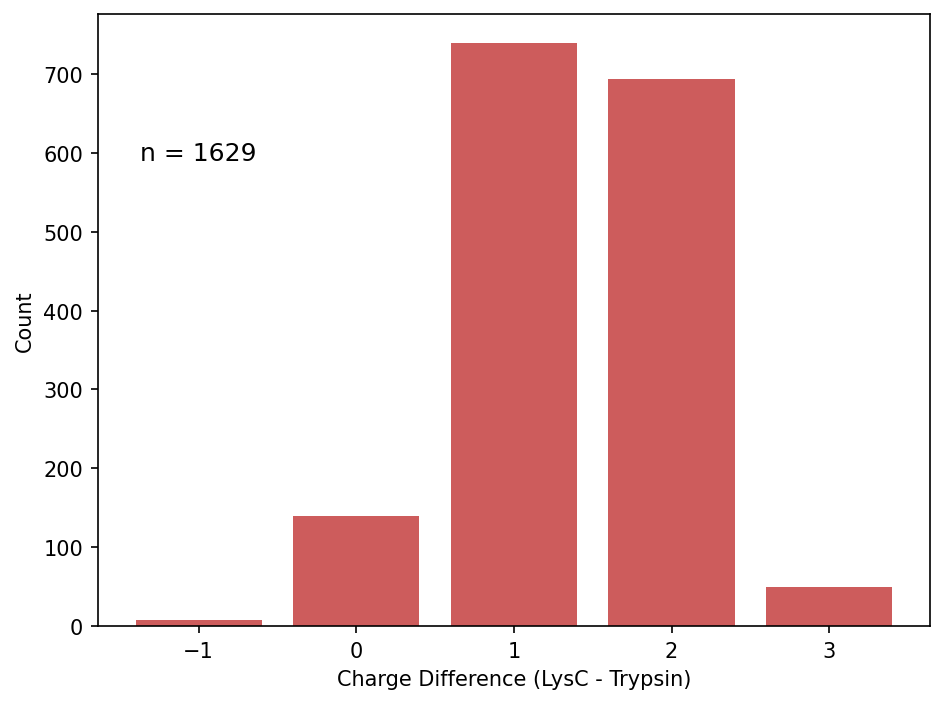

In [7]:
# plot results
fig, ax = plt.subplots(dpi = 150)
ax.bar(charge_diff_vals, count_vals, color = 'indianred')
TEXT = 'n = ' + str(len(delta_charge))
ax.text(-1, 600, TEXT, fontsize=12, ha='center', va='center')
ax.set_xlabel('Charge Difference (LysC - Trypsin)')
ax.set_ylabel('Count')

plt.tight_layout()

In [8]:
index_1 = charge_diff_vals.index(1)
index_2 = charge_diff_vals.index(2)
total_count = sum(count_vals)
percent_1 = round(count_vals[index_1] / total_count * 100, 2)
percent_2 = round(count_vals[index_2] / total_count * 100, 2)
print(f'Percent with +1 charge state: {percent_1}%')
print(f'Percent with +2 charge state: {percent_2}%')

Percent with +1 charge state: 45.37%
Percent with +2 charge state: 42.54%


In [9]:
# start looking at scar fragmentation
# sort data based on ion type
scar_to_intensity = {}
SCAR_to_int = {}
SCAR = 'GGRLRLVLHLTSE'
ion_types = ['b', 'y']
for i in range(0, len(SCAR)+1):
    scarseq = SCAR[0:i]
    scar_to_intensity[scarseq] = {}
    SCAR_to_int[scarseq] = 0
    for iontype in ion_types:
        scar_to_intensity[scarseq][iontype] = {}
        for charge in range(1,4):
            scar_to_intensity[scarseq][iontype][charge] = 0

for precursor in loaded_dict['LysC']['experimental'].keys():
    ion_df = loaded_dict['LysC']['experimental'][precursor]['ion_df']
    for r in ion_df.to_dict(orient='records'):
        if '[' in r['FragmentModSeq']:
            ubscarseq = r['UbScarSeq']
            intensity = r['intensity']
            ion_charge = r['ion_charge']
            ion_type = r['ion_type']
            if intensity > 0:
                current_intensity = scar_to_intensity[ubscarseq][ion_type][ion_charge]
                scar_to_intensity[ubscarseq][ion_type][ion_charge] = current_intensity + intensity
                current_intensity = SCAR_to_int[ubscarseq]
                SCAR_to_int[ubscarseq] = current_intensity + intensity

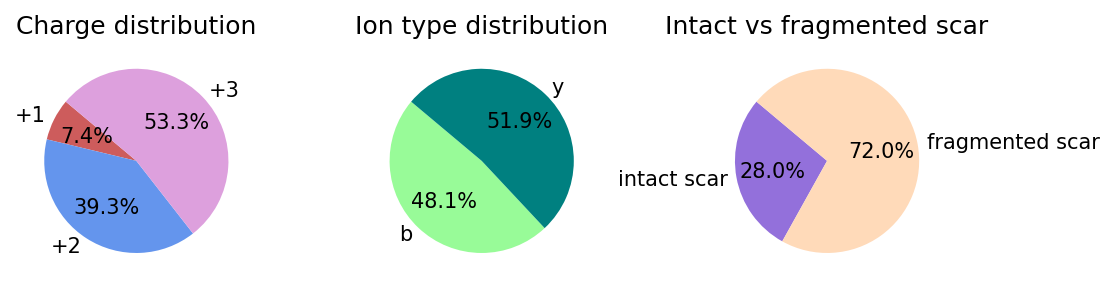

In [10]:
# visualize results
totals = {
    'b': 0,
    'y': 0,
    '1': 0,
    '2': 0,
    '3': 0,
    'intact': 0,
    'fragmented': 0
}

# Calculate totals
for scar, scar_data in scar_to_intensity.items():
    for ion, ion_data in scar_data.items():
        for charge, intensity in ion_data.items():
            totals[ion] += intensity
            if charge == 1:
                totals['1'] += intensity
            elif charge == 2:
                totals['2'] += intensity
            elif charge == 3:
                totals['3'] += intensity
            
            if scar == 'GGRLRLVLHLTSE':
                totals['intact'] += intensity
            else:
                totals['fragmented'] += intensity

fig, axes = plt.subplots(1, 3, dpi=150, figsize=(7.5, 3))

ax = axes[0]
sizes = [totals['1'], totals['2'], totals['3']]
labels = ['+1', '+2', '+3']
colors = ['indianred', 'cornflowerblue', 'plum']
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
ax.set_title('Charge distribution')

ax = axes[1]
sizes = [totals['b'], totals['y']]
labels = ['b', 'y']
colors = ['palegreen', 'teal']
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
ax.set_title('Ion type distribution')

ax = axes[2]
sizes = [totals['intact'], totals['fragmented']]
labels = ['intact scar', 'fragmented scar']
colors = ['mediumpurple', 'peachpuff']
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
ax.set_title('Intact vs fragmented scar')

plt.tight_layout()

In [11]:
# look at b-ion intensities across all LysC spectra -- compare with Prosit predctions

peptide = 'ESTLHLVLRLRGG'
frag_mzs = return_ion_types(peptide, 2)

b_ion_mz_to_intensity = {mz: 0 for mz, ion in frag_mzs.items() if ion[0].startswith('b')}

# search for ions in experimental data
for precursor, data in loaded_dict['LysC']['experimental'].items():
    mz_array = data['mz_array']
    int_array = data['intensity_array']
    for mz in b_ion_mz_to_intensity:
        within_range = (mz_array > mz - 20e-6 * mz) & (mz_array < mz + 20e-6 * mz)
        b_ion_mz_to_intensity[mz] += np.sum(int_array[within_range])

# normalize
exp_bion_mzs = list(b_ion_mz_to_intensity.keys())
int_list = list(b_ion_mz_to_intensity.values())
exp_bion_ints = np.array(int_list) / max(int_list)

Text(400, -0.95, 'peptide ESTLHLVLRLRGG +2H')

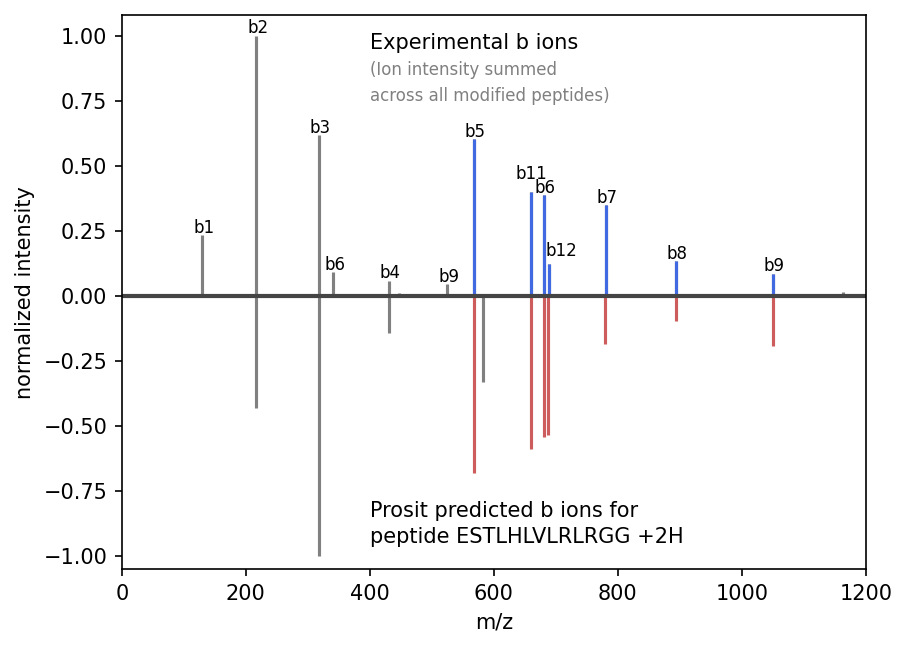

In [12]:
# plot results

fig, ax = plt.subplots(dpi=150)

# plot experimental b ions
ax.vlines(exp_bion_mzs, 0, exp_bion_ints, color='gray')
ax.set_ylim(0, 1.05)

diagnostic_ions_1 = ['b5', 'b6', 'b7', 'b8', 'b9']
diagnostic_ions_2 = ['b11', 'b12']
exp_b_diagnostics_mz, exp_b_diagnostics_int = [], []

for mz, norm_int in zip(exp_bion_mzs, exp_bion_ints):
    if norm_int > 0.03:
        ion_type, ion_charge = frag_mzs[mz]
        ion_text = ion_type
        ax.text(mz - (25 if ion_text == 'b11' else 5 if ion_text == 'b12' else 15), 
                norm_int + (0.05 if ion_text == 'b11' else 0.03 if ion_text == 'b12' else 0.01), 
                ion_text, fontsize=8)
        if (ion_text in diagnostic_ions_1 and ion_charge == 1) or (ion_text in diagnostic_ions_2 and ion_charge == 2):
            exp_b_diagnostics_mz.append(mz)
            exp_b_diagnostics_int.append(norm_int)

ax.text(400, 0.95, 'Experimental b ions')
ax.text(400, 0.85, '(Ion intensity summed', fontsize=8, color='gray')
ax.text(400, 0.75, 'across all modified peptides)', fontsize=8, color='gray')
ax.vlines(exp_b_diagnostics_mz, 0, exp_b_diagnostics_int, color='royalblue')

# plot Prosit predicted b-ions
precursor = (peptide, 2)
prosit_data = loaded_dict['LysC']['Prosit'][precursor]
mz_array = prosit_data['mz_array']
intensity_array = prosit_data['intensity_array']
frag_mzs = return_ion_types(precursor[0], precursor[1])

frag_mzs_rounded = {round(mz, 0): ion for mz, ion in frag_mzs.items()}
mz_array_rounded = np.round(mz_array, 0)

ions_to_plot_1 = [('b2', 1), ('b3', 1), ('b4', 1), ('b10', 2)]
ions_to_plot_2 = [('b5', 1), ('b6', 1), ('b7', 1), ('b8', 1), ('b9', 1), ('b11', 2), ('b12', 2)]

prosit_bion_mzs, intensities_to_plot_1 = [], []
prosit_b_diagnostics_mz, intensities_to_plot_2 = [], []

for mz, intensity in zip(mz_array_rounded, intensity_array):
    ion = frag_mzs_rounded.get(mz)
    if ion in ions_to_plot_1:
        prosit_bion_mzs.append(mz)
        intensities_to_plot_1.append(intensity)
    elif ion in ions_to_plot_2:
        prosit_b_diagnostics_mz.append(mz)
        intensities_to_plot_2.append(intensity)

max_intensity = max(intensities_to_plot_1)
prosit_bion_int = np.array(intensities_to_plot_1) / max_intensity
prosit_b_diagnostics_int = np.array(intensities_to_plot_2) / max_intensity

ax.vlines(prosit_bion_mzs, 0, -prosit_bion_int, color='gray')
ax.vlines(prosit_b_diagnostics_mz, 0, -prosit_b_diagnostics_int, color='indianred')

ax.set_ylim(-1.05, 1.08)
ax.set_xlabel('m/z')
ax.set_ylabel('normalized intensity')
ax.plot([0, 1500], [0, 0], color='#444444', linewidth=2)
ax.set_xlim(0, 1200)
ax.text(400, -0.85, 'Prosit predicted b ions for')
ax.text(400, -0.95, 'peptide ESTLHLVLRLRGG +2H')

In [13]:
# score all spectra for diagnostic ions (b5, b11, b6, b12, b7, b8, b9) using prosit intensities

frag_mzs_rounded = { round(mz,0) : frag_mzs[mz] for mz in frag_mzs.keys()}


ion_type_list = []
for index, mz in enumerate(mz_array_rounded):
        if mz in frag_mzs_rounded.keys():
            ion_type_list.append((frag_mzs_rounded[mz][0], frag_mzs_rounded[mz][1]))

            
ions_to_plot = [('b5', 1),('b6', 1),('b7', 1),('b8', 1),('b9', 1),('b11', 2),('b12', 2)]


diagnostic_bions_prosit = []
diagnostic_int_prosit = []
ion_text = []
for index, ion in enumerate(ion_type_list):
    if ion in ions_to_plot:
        ion_string = ion[0] + ' +' + str(ion[1])
        ion_text.append(ion_string)
        diagnostic_bions_prosit.append(mz_array[index])
        diagnostic_int_prosit.append(intensity_array[index])
        
MAX = max(diagnostic_int_prosit)

diagnostic_int_prosit_norm = np.array(diagnostic_int_prosit)/MAX

diagnostic_ions_scores_prosit = []
for precursor in loaded_dict['LysC']['experimental']:
    mz_array = loaded_dict['LysC']['experimental'][precursor]['mz_array']
    int_array = loaded_dict['LysC']['experimental'][precursor]['intensity_array']
    
    score, important_exp_mz, final_int, prosit_mz, prosit_int = cosine_similarity(mz_array, int_array, diagnostic_bions_prosit, diagnostic_int_prosit, precursor[0], softmax = False, dropb1y1 = True, summed_error=False)
    diagnostic_ions_scores_prosit.append(score)

In [14]:
# score all spectra for diagnostic ions (b5, b11, b6, b12, b7, b8, b9) using experimental intensities

precursor_to_bion_score = {}
b_ion_mz_to_intensity = {}


ions_to_plot = [('b5', 1),('b6', 1),('b7', 1),('b8', 1),('b9', 1),('b11', 2),('b12', 2)]
for mz in frag_mzs.keys():
    if frag_mzs[mz] in ions_to_plot:
        b_ion_mz_to_intensity[mz] = 0
        
 

for precursor in loaded_dict['LysC']['experimental']:
    mz_array = loaded_dict['LysC']['experimental'][precursor]['mz_array']
    int_array = loaded_dict['LysC']['experimental'][precursor]['intensity_array']
    for mz in b_ion_mz_to_intensity.keys():
        upper_lim = mz + 20e-6*mz
        lower_lim = mz - 20e-6*mz
        for index, MZ in enumerate(mz_array):
            if MZ < upper_lim and MZ > lower_lim:
                current_intensity = b_ion_mz_to_intensity[mz]
                b_ion_mz_to_intensity[mz] = current_intensity + int_array[index]
                
                
b_ion_mzs = list(b_ion_mz_to_intensity.keys())
b_ions_int = list(b_ion_mz_to_intensity.values())
MAX = max(b_ions_int)
b_ions_int_norm = np.array(b_ions_int)/MAX


diagnostic_ions_scores_experimental = []
for precursor in loaded_dict['LysC']['experimental']:
    mz_array = loaded_dict['LysC']['experimental'][precursor]['mz_array']
    int_array = loaded_dict['LysC']['experimental'][precursor]['intensity_array']
    
    score, important_exp_mz, final_int, prosit_mz, prosit_int = cosine_similarity(mz_array, int_array, b_ion_mzs, b_ions_int_norm, precursor[0], softmax = False, dropb1y1 = True, summed_error=False)
    diagnostic_ions_scores_experimental.append(score)
    precursor_to_bion_score[precursor] = score

(0.0, 1.0)

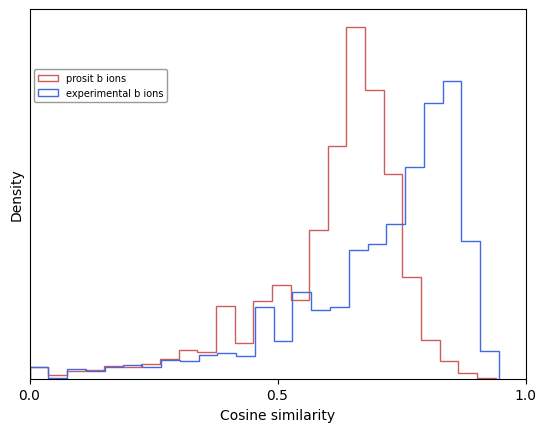

In [15]:
# plot score results
fig, ax = plt.subplots()
ax.hist(diagnostic_ions_scores_prosit, bins = 25, histtype = 'step', label = 'prosit b ions', density = True, color = 'indianred')
ax.hist(diagnostic_ions_scores_experimental, bins = 25, histtype = 'step', label = 'experimental b ions', density = True, color = 'royalblue')
legend = ax.legend(loc='upper left', bbox_to_anchor=(0, 0.85), ncol=1, fontsize=7, frameon=True, edgecolor='grey', fancybox=True)
ax.set_xlabel('Cosine similarity')
ax.set_ylabel('Density')
ax.set_xlim(0,1)
ax.set_yticks([])
ax.set_xticks([0,0.5,1])
ax.set_xlim(0,1)

In [16]:
# look at y-ion intensities across all LysC spectra -- compare with Prosit predctions
ion_type_to_intensity = {}
for index, mz in enumerate(mz_array_rounded):
        if mz in frag_mzs_rounded.keys():
            ion_type = frag_mzs_rounded[mz][0]
            charge = frag_mzs_rounded[mz][1]
            ion_type_to_intensity[(ion_type, charge)] = intensity_array[index]


ions = ['y2','y3','y4','y5','y6','y7','y8','y9','y10','y11','y12']
prosit_ion_to_intensity = {}
for ion in ions:
    total_intensity = 0
    for charge in range(1,3):
        ION = (ion, charge)
        if ION in ion_type_to_intensity.keys():
            total_intensity = total_intensity + ion_type_to_intensity[ION]
    prosit_ion_to_intensity[ion] = total_intensity
    
exp_ion_to_intensity = {}

for scar in scar_to_intensity.keys():
    ion = 'y' + str(len(scar))
    if ion in ions:
        total_intensity = 0
        for ion_type in scar_to_intensity[scar].keys():
            for charge in scar_to_intensity[scar][ion_type].keys():
                total_intensity = total_intensity + scar_to_intensity[scar][ion_type][charge]
        exp_ion_to_intensity [ion] = total_intensity
exp_ion_to_intensity_norm = {}
MAX = max(exp_ion_to_intensity.values())
for ion in exp_ion_to_intensity:
    VALUE = exp_ion_to_intensity[ion] / MAX
    exp_ion_to_intensity_norm[ion] = VALUE

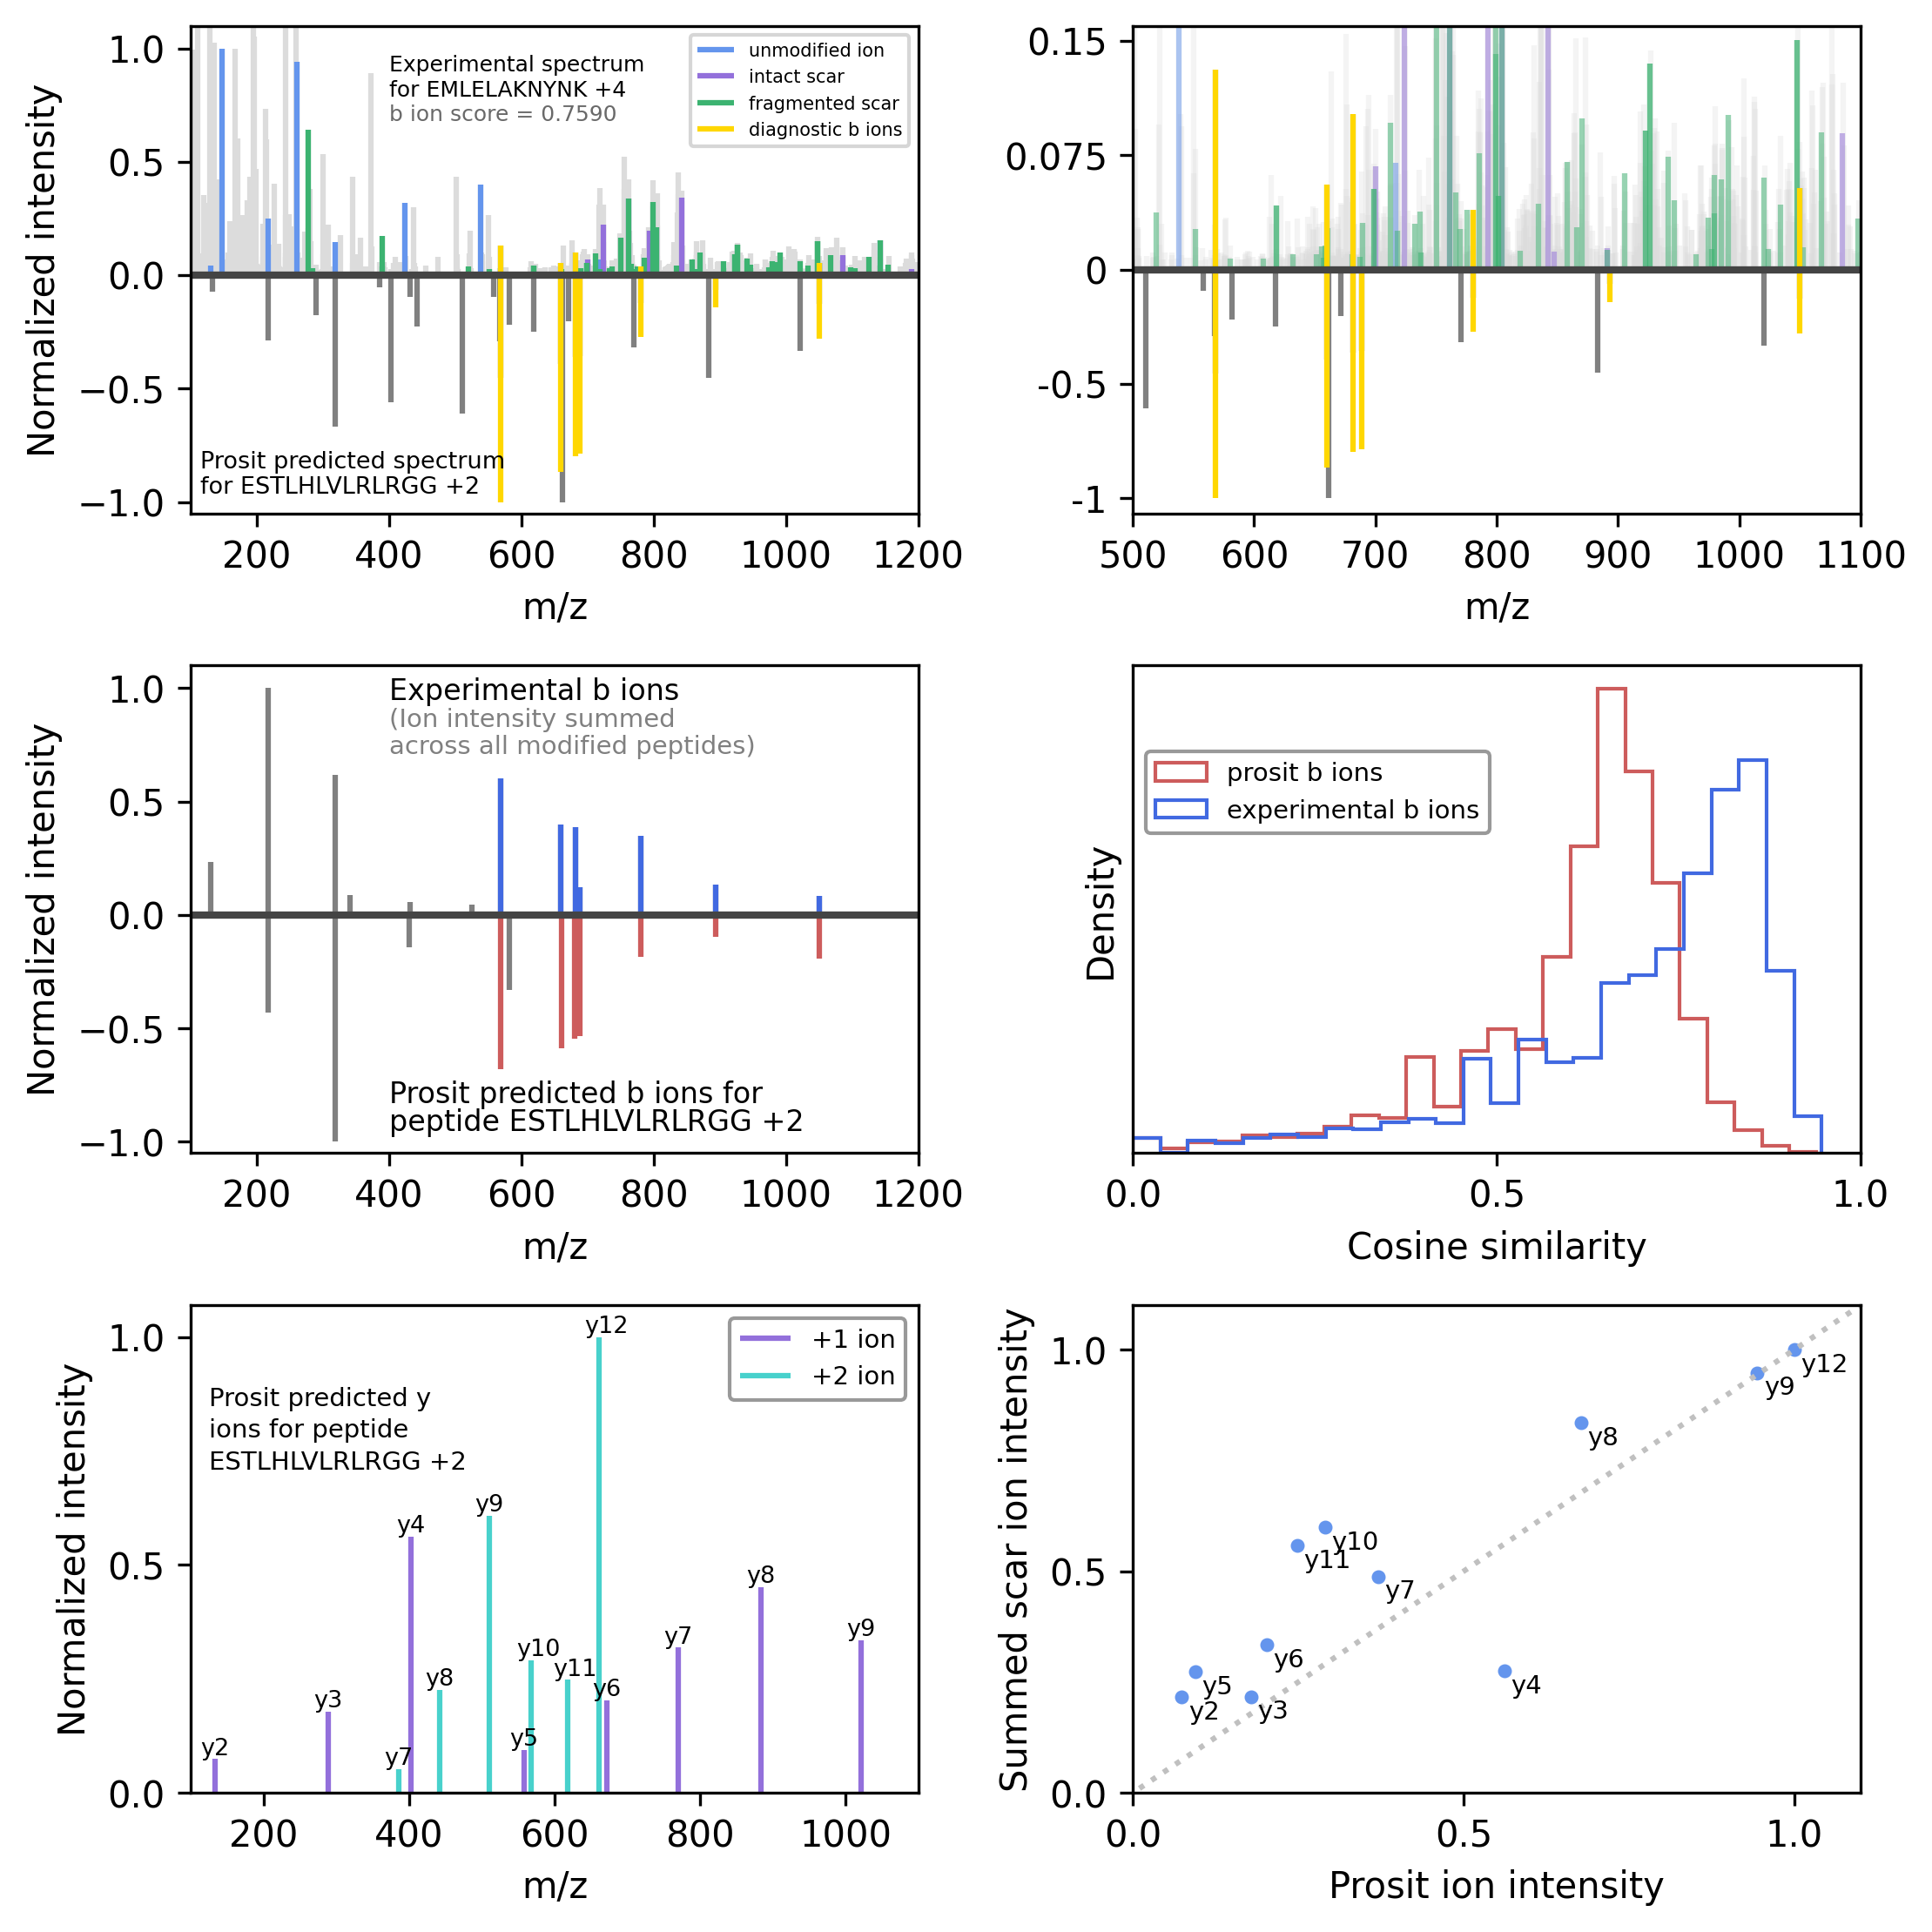

In [17]:
# plot fragmentation results in one figure
fig, axes = plt.subplots(3, 2, dpi=300, figsize=(7.5, 7.5))

# plot spectra of example peptide
precursor = ('EMLELAKNYNK', 4)
exp_mz = loaded_dict['LysC']['experimental'][precursor]['mz_array']
exp_int = np.array(loaded_dict['LysC']['experimental'][precursor]['intensity_array'])
ion_df = loaded_dict['LysC']['experimental'][precursor]['ion_df']

# categorize matched fragments
unmod_frag_mzs, unmod_frag_int, intact_scar_mzs, intact_scar_int, frag_scar_mzs, frag_scar_int = [], [], [], [], [], []
for r in ion_df.to_dict(orient='records'):
    if r['intensity'] > 0:
        if '[' not in r['FragmentModSeq']:
            unmod_frag_mzs.append(r['mz'])
            unmod_frag_int.append(r['intensity'])
        elif r['UbScarSeq'] == 'GGRLRLVLHLTSE':
            intact_scar_mzs.append(r['mz'])
            intact_scar_int.append(r['intensity'])
        else:
            frag_scar_mzs.append(r['mz'])
            frag_scar_int.append(r['intensity'])

# match diagnostic b ions
diagnostic_bions, diagnostic_intensities = [], []
for mz in exp_mz:
    for b_ion_mz in diagnostic_bions_prosit:
        if b_ion_mz * (1 - 20e-6) < mz < b_ion_mz * (1 + 20e-6):
            diagnostic_bions.append(mz)
            diagnostic_intensities.append(exp_int[np.where(exp_mz == mz)][0])

# normalize ion intensities
MAX = max(max(unmod_frag_int), max(intact_scar_int), max(frag_scar_int))
unmod_frag_int_norm = np.array(unmod_frag_int) / MAX
intact_scar_int_norm = np.array(intact_scar_int) / MAX
frag_scar_int_norm = np.array(frag_scar_int) / MAX
diagnostic_intensities_norm = np.array(diagnostic_intensities) / MAX
exp_int_norm = np.array(exp_int) / MAX

# plot experimental data
ax = axes[0, 0]
ax.vlines(exp_mz, 0, exp_int_norm, color='gainsboro')
ax.vlines(unmod_frag_mzs, 0, unmod_frag_int_norm, color='cornflowerblue', label='unmodified ion')
ax.vlines(intact_scar_mzs, 0, intact_scar_int_norm, color='mediumpurple', label='intact scar')
ax.vlines(frag_scar_mzs, 0, frag_scar_int_norm, color='mediumseagreen', label='fragmented scar')
ax.vlines(diagnostic_bions, 0, diagnostic_intensities_norm, color='gold', label='diagnostic b ions')
ax.set_xlabel('m/z')
ax.set_ylim(-1.05, 1.05)
ax.set_ylabel('Normalized intensity')
ax.set_xlim(100, 1200)
ax.legend(loc='upper right', fontsize=5)
ax.text(400, 0.9, 'Experimental spectrum', color='k', fontsize=6)
ax.text(400, 0.79, f'for {precursor[0]} +{precursor[1]}', color='k', fontsize=6)
ax.text(400, 0.68, f'b ion score = {precursor_to_bion_score[precursor]:.4f}', color='dimgray', fontsize=6)

# Prosit prediction data
precursor = ('ESTLHLVLRLRGG', 2)
mz_array = loaded_dict['LysC']['Prosit'][precursor]['mz_array']
intensity_array = loaded_dict['LysC']['Prosit'][precursor]['intensity_array']
frag_mzs = return_ion_types(precursor[0], precursor[1])
mz_array_rounded = np.round(mz_array, 0)

# identify ion types
ion_type_list = [(frag_mzs_rounded[mz][0], frag_mzs_rounded[mz][1]) for mz in mz_array_rounded if mz in frag_mzs_rounded]

# plot Prosit diagnostic ions
ions_to_plot = [('b5', 1), ('b6', 1), ('b7', 1), ('b8', 1), ('b9', 1), ('b11', 2), ('b12', 2)]
mzs_to_plot, intensities_to_plot, ion_text = [], [], []
for index, ion in enumerate(ion_type_list):
    if ion in ions_to_plot:
        ion_text.append(f"{ion[0]} +{ion[1]}")
        mzs_to_plot.append(mz_array[index])
        intensities_to_plot.append(intensity_array[index])

intensities_to_plot_norm = np.array(intensities_to_plot) / max(intensities_to_plot)
ax.vlines(mz_array, 0, -intensity_array, color='gray')
ax.vlines(mzs_to_plot, 0, -intensities_to_plot_norm, color='gold')
ax.plot([0, 1700], [0, 0], color='#444444', linewidth=2)
ax.text(115, -0.85, 'Prosit predicted spectrum', color='k', fontsize=6.5)
ax.text(115, -0.96, f'for {precursor[0]} +{precursor[1]}', color='k', fontsize=6.5)
ax.set_ylim(-1.05, 1.1)

# plot spectra on different axes
ax = axes[0, 1]
ax.vlines(exp_mz, 0, exp_int_norm, color='gainsboro', alpha=0.3)
ax.vlines(unmod_frag_mzs, 0, unmod_frag_int_norm, color='cornflowerblue', alpha=0.5)
ax.vlines(intact_scar_mzs, 0, intact_scar_int_norm, color='mediumpurple', alpha=0.5)
ax.vlines(frag_scar_mzs, 0, frag_scar_int_norm, color='mediumseagreen', alpha=0.5)
ax.vlines(diagnostic_bions, 0, diagnostic_intensities_norm, color='gold')
ax.vlines(mz_array, 0, -0.15 * intensity_array, color='gray')
ax.vlines(mzs_to_plot, 0, -0.15 * intensities_to_plot_norm, color='gold')
ax.plot([0, 1700], [0, 0], color='#444444', linewidth=2)
ax.set_xlabel('m/z')
ax.set_ylim(-0.16, 0.16)
ax.set_xlim(500, 1100)
ax.set_yticks([-0.15, -0.075, 0, 0.075, 0.15], ['-1', '-0.5', '0', '0.075', '0.15'])

# plot b ion spectra
ax = axes[1, 0]
ax.vlines(exp_bion_mzs, 0, exp_bion_ints, color='gray')
ax.vlines(exp_b_diagnostics_mz, 0, exp_b_diagnostics_int, color='royalblue')
ax.vlines(prosit_bion_mzs, 0, -prosit_bion_int, color='gray')
ax.vlines(prosit_b_diagnostics_mz, 0, -prosit_b_diagnostics_int, color='indianred')
ax.plot([0, max(mzs_to_plot) + 300], [0, 0], color='#444444', linewidth=2)
ax.set_ylim(-1.05, 1.1)
ax.set_xlim(100, 1200)
ax.set_xlabel('m/z')
ax.set_ylabel('Normalized intensity')
ax.text(400, 0.95, 'Experimental b ions', fontsize=8)
ax.text(400, 0.83, '(Ion intensity summed', fontsize=7, color='gray')
ax.text(400, 0.71, 'across all modified peptides)', fontsize=7, color='gray')
ax.text(400, -0.83, 'Prosit predicted b ions for', fontsize=8)
ax.text(400, -0.95, 'peptide ESTLHLVLRLRGG +2', fontsize=8)

# plot b ion cosine similarities
ax = axes[1, 1]
ax.hist(diagnostic_ions_scores_prosit, bins=25, histtype='step', label='prosit b ions', density=True, color='indianred')
ax.hist(diagnostic_ions_scores_experimental, bins=25, histtype='step', label='experimental b ions', density=True, color='royalblue')
ax.legend(loc='upper left', bbox_to_anchor=(0, 0.85), ncol=1, fontsize=7, frameon=True, edgecolor='grey', fancybox=True)
ax.set_xlabel('Cosine similarity')
ax.set_ylabel('Density')
ax.set_xlim(0, 1)
ax.set_yticks([])
ax.set_xticks([0, 0.5, 1])


# plot prosit y ion intensities
ax = axes[2,0]
# match ions
mz_array_rounded = np.round(mz_array, 0)
ion_type_list = []
for index, mz in enumerate(mz_array_rounded):
        if mz in frag_mzs_rounded.keys():
            ion_type = frag_mzs_rounded[mz][0]
            charge = frag_mzs_rounded[mz][1]
            ion_type_list.append((ion_type, charge))
ions_to_plot_1 = [('y9', 1),('y8', 1),('y7', 1),('y6', 1),('y5', 1),('y4', 1),('y3', 1),('y2', 1)]            
ions_to_plot_2 = [('y12', 2),('y11', 2),('y10', 2),('y9', 2),('y8', 2),('y7', 2)]         
mzs_to_plot = []
intensities_to_plot = []
mzs_to_plot_1 = []
intensities_to_plot_1 = []
mzs_to_plot_2 = []
intensities_to_plot_2 = []
ion_text = []
for index, ion in enumerate(ion_type_list):
    if ion in ions_to_plot_1:
        ion_string = ion[0]
        ion_text.append(ion_string)
        mzs_to_plot_1.append(mz_array[index])
        intensities_to_plot_1.append(intensity_array[index])
        mzs_to_plot.append(mz_array[index])
        intensities_to_plot.append(intensity_array[index])
    if ion in ions_to_plot_2:
        ion_string = ion[0]
        ion_text.append(ion_string)
        mzs_to_plot_2.append(mz_array[index])
        intensities_to_plot_2.append(intensity_array[index])
        mzs_to_plot.append(mz_array[index])
        intensities_to_plot.append(intensity_array[index])
    
    
# plot data
ax.vlines(mzs_to_plot_1, 0, intensities_to_plot_1, color = 'mediumpurple',label = '+1 ion' )
ax.vlines(mzs_to_plot_2, 0, intensities_to_plot_2, color = 'mediumturquoise', label = '+2 ion' )
[ax.text(mz - 20, intensity + 0.01, text, fontsize=6.5) for mz, intensity, text in zip(mzs_to_plot, intensities_to_plot, ion_text)]  
ax.set_xlim(100,1100)
ax.set_ylim(0,1.07)
ax.set_xlabel('m/z')
legend = ax.legend(loc='upper right', fontsize = 7, frameon=True,edgecolor='grey', fancybox=True)
ax.text(125, 0.85, 'Prosit predicted y', fontsize = 7)
ax.text(125, .78, 'ions for peptide', fontsize = 7)
ax.text(125, .71, 'ESTLHLVLRLRGG +2', fontsize = 7)
ax.set_ylabel('Normalized intensity')
ax.set_yticks([0,0.5,1])

# plot y intensity scatterplot
ax = axes[2,1]
ax.plot((-1,2),(-1,2),color='silver', linestyle='dotted')
ax.scatter(prosit_ion_to_intensity.values(), exp_ion_to_intensity_norm.values(), color = 'cornflowerblue', s = 8)
ax.set_xlabel('Prosit ion intensity')
ax.set_ylabel('Summed scar ion intensity')
for ion, x in prosit_ion_to_intensity.items():
    y = exp_ion_to_intensity_norm[ion]
    ax.text(x + 0.01, y - 0.05, str(ion), fontsize=7)
ax.set_ylim(0,1.1)
ax.set_xlim(0,1.1)
ax.set_yticks([0,0.5,1])
ax.set_xticks([0,0.5,1])


plt.tight_layout()

In [18]:
# supplimental figures

In [19]:
# find b-ion quintiles
percents = [20, 40, 50, 60, 80, 100]
score_list = list(precursor_to_bion_score.values())
quintiles = np.percentile(score_list, percents)

for p, q in zip(percents, quintiles):
    print(f'Percentile: {p}, Quintile: {round(q, 3)}')

for precursor, score in precursor_to_bion_score.items():
    for quintile_value in quintiles:
        if score >= quintile_value - 0.0001 and score <= quintile_value + 0.0001:
            print(f'Precursor: {precursor}, Score: {round(score,3)}')

Percentile: 20, Quintile: 0.57
Percentile: 40, Quintile: 0.713
Percentile: 50, Quintile: 0.759
Percentile: 60, Quintile: 0.793
Percentile: 80, Quintile: 0.843
Percentile: 100, Quintile: 0.946
Precursor: ('KREHHIEQLNDKLSK', 6), Score: 0.57
Precursor: ('NNGGAAAMEKLSSIK', 4), Score: 0.57
Precursor: ('YDLDFKSPDDPSRYISPDQLADLYK', 6), Score: 0.759
Precursor: ('TVCGENLPPLTYDQLKDLNLLDRCIK', 4), Score: 0.759
Precursor: ('EILVGDVGQTVDDPYATFVKMLPDK', 4), Score: 0.843
Precursor: ('DDVAQTDLLQIDPNFGSKEDFDSLLQSAK', 5), Score: 0.759
Precursor: ('EVMQEVAQLSQFDEELYKVIGK', 6), Score: 0.843
Precursor: ('NALNIGMVEEVLQSSDETKSLEEAQEWLK', 5), Score: 0.843
Precursor: ('ASDYQRLDQKS', 4), Score: 0.793
Precursor: ('LQKLNEVRK', 4), Score: 0.713
Precursor: ('HPDDEMMKRNMAYYK', 5), Score: 0.759
Precursor: ('LALKWHPDKNPENK', 4), Score: 0.793
Precursor: ('KLESKLDYKPV', 4), Score: 0.759
Precursor: ('AAQEEYVKRALANSLACQGK', 5), Score: 0.793
Precursor: ('QDLLAEKVLAGK', 4), Score: 0.843
Precursor: ('LDSTDFTGTIKLLNENSYVPREAG

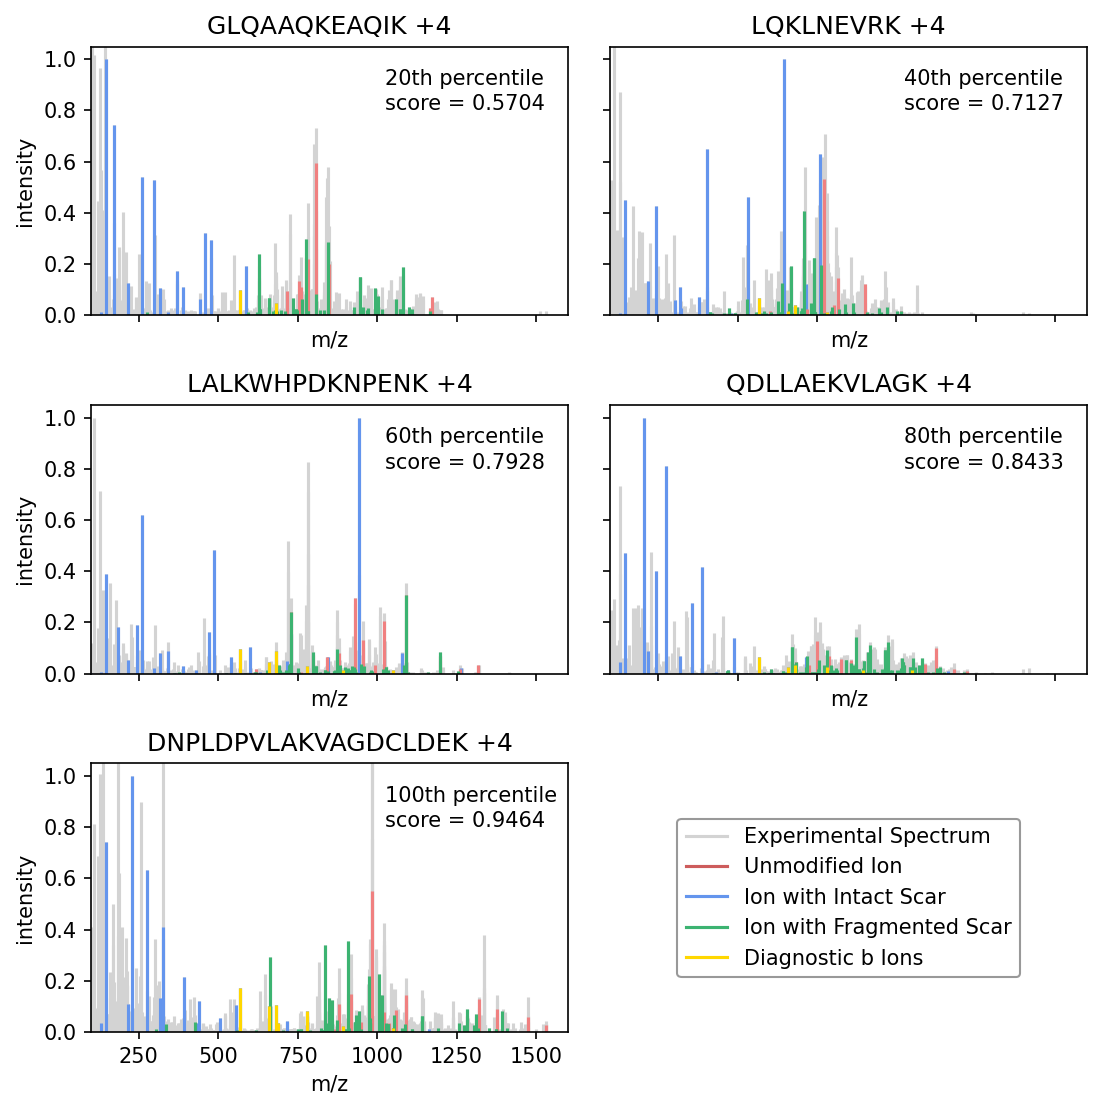

In [20]:
# plot spectra for each quintile -- all +4 precursors


precursors_to_score = {('GLQAAQKEAQIK', 4): 0.5703837573020247,
                      ('LQKLNEVRK', 4): 0.712655801778372,
                      ('LALKWHPDKNPENK', 4): 0.792760684472308,
                      ('QDLLAEKVLAGK', 4): 0.8432548686035909,
                      ('DNPLDPVLAKVAGDCLDEK', 4): 0.9464167321998848}
percentile_list = [20, 40, 60, 80, 100]

precursors_to_score_list = list(precursors_to_score.keys())
fig, axes = plt.subplots(3, 2, dpi = 150, figsize = (7.5, 7.5), sharex = True, sharey = True)
for index, precursor in enumerate(precursors_to_score_list):
    row = index % 2
    col = int(index / 2)
    ax = axes[col, row]
    percentile_string = str(percentile_list[index]) + 'th percentile'
    exp_mz = loaded_dict['LysC']['experimental'][precursor]['mz_array']
    exp_int = np.array(loaded_dict['LysC']['experimental'][precursor]['intensity_array'])

    ion_df =  loaded_dict['LysC']['experimental'][precursor]['ion_df']

    unmod_frag_mzs = []
    unmod_frag_int = []
    intact_scar_mzs = []
    intact_scar_int = []
    frag_scar_mzs = []
    frag_scar_int = []

    # annotate matched frags
    for r in ion_df.to_dict(orient='records'):
        if r['intensity'] > 0:
            if '[' not in r['FragmentModSeq']:
                unmod_frag_mzs.append(r['mz'])
                unmod_frag_int.append(r['intensity'])
            elif r['UbScarSeq'] == 'GGRLRLVLHLTSE':
                intact_scar_mzs.append(r['mz'])
                intact_scar_int.append(r['intensity'])
            else:
                frag_scar_mzs.append(r['mz'])
                frag_scar_int.append(r['intensity']) 


    # match diagnostic bions
    diagnostic_bions = []
    diagnostic_intensities = []


    for index, mz in enumerate(exp_mz):
        for b_ion_mz in diagnostic_bions_prosit:
            upper_lim = b_ion_mz + b_ion_mz * 20e-6
            lower_lim = b_ion_mz - b_ion_mz * 20e-6
            if mz > lower_lim and mz < upper_lim:
                diagnostic_bions.append(mz)
                diagnostic_intensities.append(exp_int[index])
    all_mzs = [unmod_frag_int, intact_scar_int, frag_scar_int, diagnostic_intensities ]
    MAX = max(max(unmod_frag_int), max(intact_scar_int), max(frag_scar_int))

            
    # normalize matched frags           
    unmod_frag_int_norm = np.array(unmod_frag_int) / MAX
    intact_scar_int_norm = np.array(intact_scar_int) / MAX 
    frag_scar_int_norm = np.array(frag_scar_int) / MAX
    diagnostic_intensities_norm = np.array(diagnostic_intensities)/MAX
    exp_int_norm = np.array(exp_int)/MAX
            

    ax.vlines(exp_mz, 0, exp_int_norm, color = 'lightgray')
    ax.vlines(unmod_frag_mzs, 0, unmod_frag_int_norm, color = 'cornflowerblue', label = 'unmodified ion' )
    ax.vlines(intact_scar_mzs, 0, intact_scar_int_norm, color = 'lightcoral', label = 'ion with intact scar' )
    ax.vlines(frag_scar_mzs, 0, frag_scar_int_norm, color = 'mediumseagreen', label = 'ion with fragmented scar' )
    ax.vlines(diagnostic_bions, 0, diagnostic_intensities_norm, color = 'gold', label = 'diagnostic b ions' )
    ax.set_ylim(0, 1.05)
    ax.set_xlabel('m/z')
    if row == 0:
        ax.set_ylabel('intensity')
    ax.set_xlim(100, 1600 )
    score_string = 'score = ' + str(round(precursors_to_score[precursor],4))
    ax.text(1025, 0.9, percentile_string)
    ax.text(1025, 0.8, score_string)
    legend = ax.legend(loc='lower right')
    ax.set_title(str(precursor[0])+' +'+str(precursor[1]))

# legend
legend_ax = axes[2, 1]  # Specify the position of the legend subplot
legend_ax.axis('off')
for ax in axes.flatten():
    if hasattr(ax, 'legend_') and ax.legend_ is not None:
        ax.legend_.remove()
axes[2, 1].plot([], [], color='lightgray', label='Experimental Spectrum')
axes[2, 1].plot([], [], color='indianred', label='Unmodified Ion')
axes[2, 1].plot([], [], color='cornflowerblue', label='Ion with Intact Scar')
axes[2, 1].plot([], [], color='mediumseagreen', label='Ion with Fragmented Scar')
axes[2, 1].plot([], [], color='gold', label='Diagnostic b Ions')
axes[2, 1].legend(loc='center', bbox_to_anchor=(0.5, 0.5),edgecolor='grey', fancybox=True)

plt.tight_layout()

/tmp/slurmtmp.32242156/ipykernel_7855/3732994112.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/tmp/slurmtmp.32242156/ipykernel_7855/3732994112.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


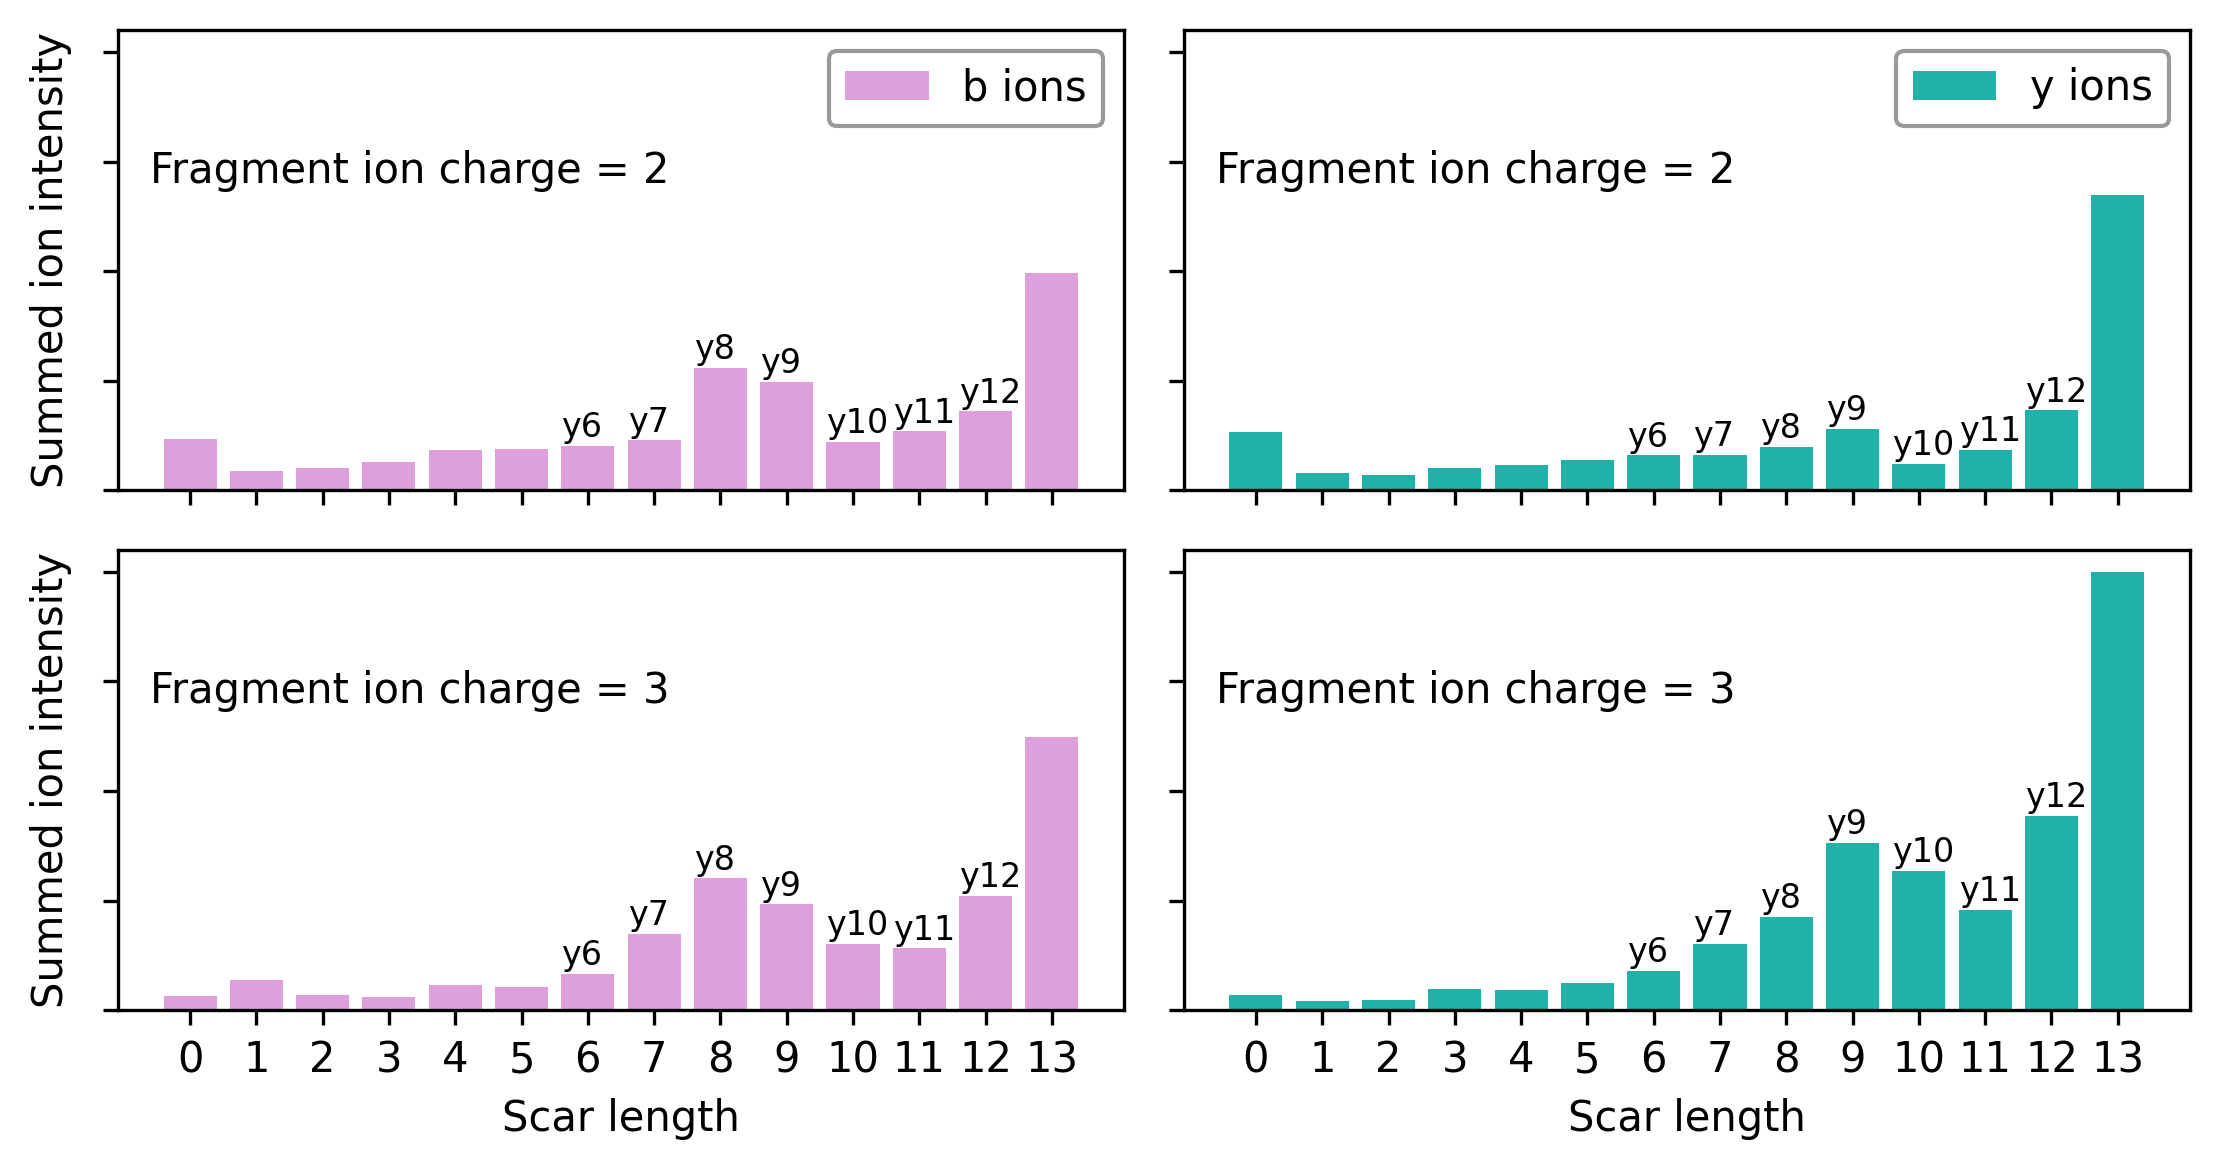

In [21]:
fig, axes = plt.subplots(2, 2, dpi=300, figsize=(7.5,4))
labels = list(range(14))
MAX = scar_to_intensity['GGRLRLVLHLTSE']['y'][3]
intensity_vals = []
text_list = ['', '', '', '', '', '', 'y6', 'y7', 'y8', 'y9', 'y10', 'y11', 'y12','']

ax = axes[0,0]
ax.set_ylim(0,1.05)
intensity_vals = []
for scar in scar_to_intensity.keys():
    intensity = scar_to_intensity[scar]['b'][2]
    intensity_vals.append(intensity/MAX)
ax.bar(scar_to_intensity.keys(), intensity_vals, color = 'plum',label = 'b ions')
ax.set_ylabel('Summed ion intensity')
ax.text(-0.6,0.7,'Fragment ion charge = 2')
ax.legend( loc='best', fontsize=10, frameon=True, facecolor='white', edgecolor='grey', fancybox=True)
for index, TEXT in enumerate(text_list):
    ax.text(index - 0.4, intensity_vals[index] + 0.02, TEXT, fontsize = 8)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax = axes[0,1]
ax.set_ylim(0,1.05)
intensity_vals = []
for scar in scar_to_intensity.keys():
    intensity = scar_to_intensity[scar]['y'][2]
    intensity_vals.append(intensity/MAX)
ax.bar(scar_to_intensity.keys(), intensity_vals, color = 'lightseagreen', label = 'y ions')
ax.legend( loc='best', fontsize=10, frameon=True, facecolor='white', edgecolor='grey', fancybox=True)
ax.text(-0.6,0.7,'Fragment ion charge = 2')
for index, TEXT in enumerate(text_list):
    ax.text(index - 0.4, intensity_vals[index] + 0.02, TEXT, fontsize = 8)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax = axes[1,0]
ax.set_ylim(0,1.05)
intensity_vals = []
for scar in scar_to_intensity.keys():
    intensity = scar_to_intensity[scar]['b'][3]
    intensity_vals.append(intensity/MAX)
ax.bar(scar_to_intensity.keys(), intensity_vals, color = 'plum')
ax.set_ylabel('Summed ion intensity')
ax.text(-0.6,0.7,'Fragment ion charge = 3')
ax.set_xticklabels(labels)
for index, TEXT in enumerate(text_list):
    ax.text(index - 0.4, intensity_vals[index] + 0.02, TEXT, fontsize = 8)
ax.set_yticklabels([])
ax.set_xlabel('Scar length')
ax = axes[1,1]
ax.set_ylim(0,1.05)
ax.set_yticklabels([])
intensity_vals = []
for scar in scar_to_intensity.keys():
    intensity = scar_to_intensity[scar]['y'][3]
    intensity_vals.append(intensity/MAX)
ax.bar(scar_to_intensity.keys(), intensity_vals, color = 'lightseagreen')
ax.text(-0.6,0.7,'Fragment ion charge = 3')
ax.set_xticklabels(labels)
for index, TEXT in enumerate(text_list):
    ax.text(index - 0.4, intensity_vals[index] + 0.02, TEXT, fontsize = 8)
ax.set_yticklabels([])
ax.set_xlabel('Scar length')

plt.tight_layout()